In [609]:
from sklearn.model_selection import train_test_split
import random
import pickle
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets, transforms

In [610]:
training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [611]:
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

In [612]:
X, y = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train / 255.0
X_test = X_test / 255.0

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_torch = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (batch, channels, height, width)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(X_train_torch, y_train_torch)
test_data  = TensorDataset(X_test_torch, y_test_torch)

BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  27839
Number of testing examples:  6960
Image data shape = (32, 32, 3)
Number of classes = 43


# Preprocess Images

In [ ]:
transform = transforms.Compose([
    transforms.RandomRotation(15),      # Randomly rotate image by ±15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip the image
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Shearing & scaling
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values
])

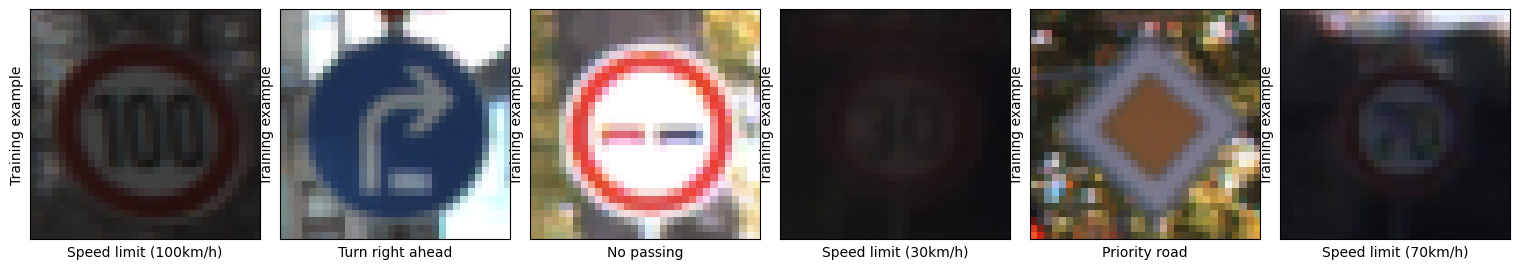

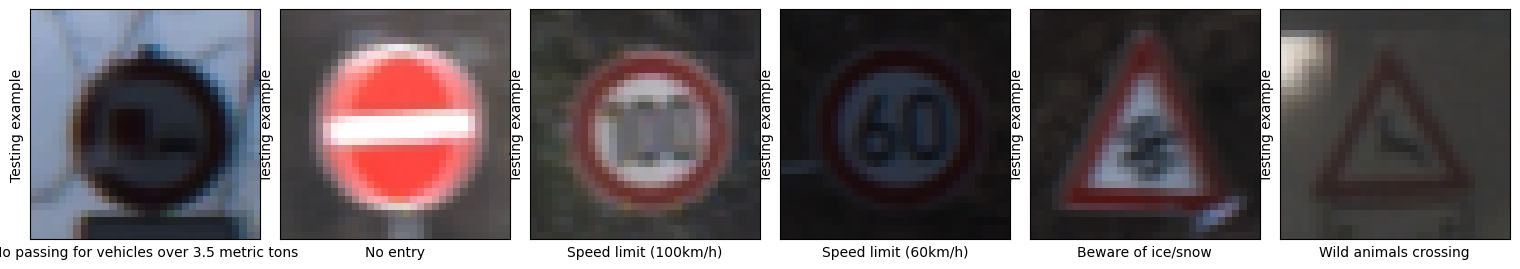

In [613]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")

In [614]:
NUM_CLASSES = len(np.unique(y_train))
EPOCHS = 20

# LeNet-5 Model

In [616]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def makeLeNet5(nclasses=43):  # Define number of classes as a parameter

    class LeNet5(nn.Module):
        def __init__(self):
            super(LeNet5, self).__init__()

            # Convolutional layers
            self.conv1 = nn.Conv2d(3, 100, kernel_size=5)
            self.bn1 = nn.BatchNorm2d(100)
            self.conv2 = nn.Conv2d(100, 150, kernel_size=3)
            self.bn2 = nn.BatchNorm2d(150)
            self.conv3 = nn.Conv2d(150, 250, kernel_size=3)
            self.bn3 = nn.BatchNorm2d(250)

            self.conv_drop = nn.Dropout2d()

            # Fully connected layers
            self.fc1 = nn.Linear(250 * 2 * 2, 350)
            self.fc2 = nn.Linear(350, nclasses)  # Define output classes

            # Spatial Transformer Network (STN)
            self.localization = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=7),
                nn.MaxPool2d(2, stride=2),
                nn.ReLU(True),
                nn.Conv2d(8, 10, kernel_size=5),
                nn.MaxPool2d(2, stride=2),
                nn.ReLU(True)
            )

            # Regressor for the 3x2 affine matrix
            self.fc_loc = nn.Sequential(
                nn.Linear(10 * 4 * 4, 32),
                nn.ReLU(True),
                nn.Linear(32, 3 * 2)
            )

            # Initialize STN transformation to identity matrix
            self.fc_loc[2].weight.data.zero_()
            self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        def stn(self, x):
            """Spatial Transformer Network forward function"""
            xs = self.localization(x)
            xs = xs.view(-1, 10 * 4 * 4)
            theta = self.fc_loc(xs)
            theta = theta.view(-1, 2, 3)
            grid = F.affine_grid(theta, x.size(), align_corners=False)
            x = F.grid_sample(x, grid, align_corners=False)
            return x

        def forward(self, x):
            # Apply STN transformation
            x = self.stn(x)

            # Forward through CNN layers
            x = self.bn1(F.max_pool2d(F.leaky_relu(self.conv1(x)), 2))
            x = self.conv_drop(x)
            x = self.bn2(F.max_pool2d(F.leaky_relu(self.conv2(x)), 2))
            x = self.conv_drop(x)
            x = self.bn3(F.max_pool2d(F.leaky_relu(self.conv3(x)), 2))
            x = self.conv_drop(x)

            # Flatten for fully connected layers
            x = x.view(-1, 250 * 2 * 2)
            x = F.relu(self.fc1(x))
            x = F.dropout(x, training=self.training)
            x = self.fc2(x)

            return F.log_softmax(x, dim=1)  # Log softmax for classification

    # Instantiate model
    net = LeNet5()

    # Define loss function and optimizer
    lossfun = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [617]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

def trainLeNet5Model(net, lossfun, optimizer, train_loader, test_loader, EPOCHS=20, lr=0.001):

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)

    # Track losses and accuracy
    trainLoss = torch.zeros(EPOCHS)
    testLoss  = torch.zeros(EPOCHS)
    trainAcc  = torch.zeros(EPOCHS)
    testAcc   = torch.zeros(EPOCHS)

    for epoch in range(EPOCHS):
        net.train()  # Set model to training mode
        batch_loss = []
        batch_acc = []

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)  # Move data to GPU if available

            optimizer.zero_grad()
            y_hat = net(X)  # Forward pass
            loss = lossfun(y_hat, y)  # Compute loss
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

            # Compute accuracy
            predictions = torch.argmax(y_hat, dim=1)
            acc = (predictions == y).float().mean().item()
            batch_acc.append(acc)

        # Store training metrics
        trainLoss[epoch] = np.mean(batch_loss)
        trainAcc[epoch] = 100 * np.mean(batch_acc)

        # ------------------------------
        # 📌 Full Evaluation on Test Set
        # ------------------------------
        net.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradients for testing
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)

                y_hat = net(X)
                loss = lossfun(y_hat, y)
                test_loss += loss.item()

                predictions = torch.argmax(y_hat, dim=1)
                correct += (predictions == y).sum().item()
                total += y.size(0)

        # Store test metrics
        testLoss[epoch] = test_loss / len(test_loader)
        testAcc[epoch]  = 100 * (correct / total)

        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {trainLoss[epoch]:.4f}, Test Loss: {testLoss[epoch]:.4f}, Train Acc: {trainAcc[epoch]:.2f}%, Test Acc: {testAcc[epoch]:.2f}%")

    print("Training Completed!")
    return trainLoss, testLoss, trainAcc, testAcc, net

In [618]:
# Initialize your LeNet-5 model
net, lossfun, optimizer = makeLeNet5()

# Train the model
trainLoss, testLoss, trainAcc, testAcc, trained_model = trainLeNet5Model(net, lossfun, optimizer, train_loader, test_loader, EPOCHS=20)

Epoch 1/20 - Train Loss: 1.2205, Test Loss: 3.9605, Train Acc: 65.27%, Test Acc: 10.56%
Epoch 2/20 - Train Loss: 0.2595, Test Loss: 4.2142, Train Acc: 92.41%, Test Acc: 4.81%
Epoch 3/20 - Train Loss: 0.1955, Test Loss: 4.3000, Train Acc: 94.35%, Test Acc: 13.00%
Epoch 4/20 - Train Loss: 0.1591, Test Loss: 6.4006, Train Acc: 95.50%, Test Acc: 5.99%
Epoch 5/20 - Train Loss: 0.1508, Test Loss: 5.1719, Train Acc: 95.62%, Test Acc: 3.85%
Epoch 6/20 - Train Loss: 0.1369, Test Loss: 7.7004, Train Acc: 96.13%, Test Acc: 7.56%
Epoch 7/20 - Train Loss: 0.1173, Test Loss: 4.6451, Train Acc: 96.63%, Test Acc: 3.48%
Epoch 8/20 - Train Loss: 0.1176, Test Loss: 5.7369, Train Acc: 96.71%, Test Acc: 6.44%
Epoch 9/20 - Train Loss: 0.1074, Test Loss: 4.3253, Train Acc: 96.94%, Test Acc: 18.82%
Epoch 10/20 - Train Loss: 0.1016, Test Loss: 5.8680, Train Acc: 97.14%, Test Acc: 10.55%
Epoch 11/20 - Train Loss: 0.0970, Test Loss: 5.6072, Train Acc: 97.40%, Test Acc: 3.06%
Epoch 12/20 - Train Loss: 0.0963, Tes

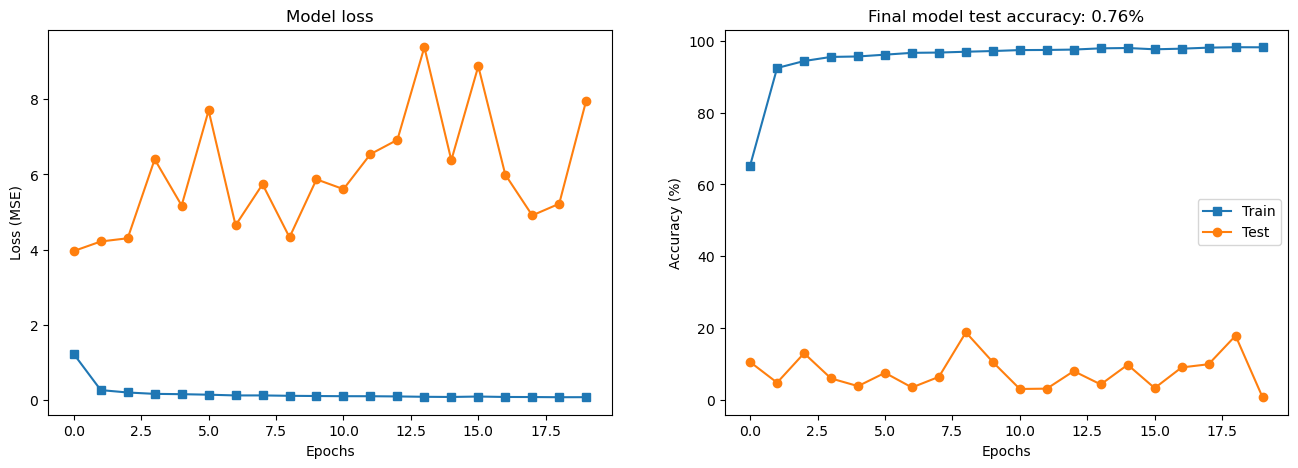

In [619]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# VGGNet Model